# Bjerknes feedback changes over time

## imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import scipy.stats
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import os
import cartopy.util
import copy

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Funcs

In [76]:
def plot_hov(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.longitude,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="both",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Longitude")
        ax.set_xticks([190, 240])
        ax.set_yticks([])
        ax.axvline(190, **kwargs)
        ax.axvline(240, **kwargs)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def plot_hov2(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.month,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="max",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data,
        orientation="horizontal",
        ticks=[-amp, 0, amp],
        label=label,
        # plot_data, orientation="horizontal", ticks=[], label=None
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        # ax.set_xlabel("Month")
        # ax.set_xticks([1, 12])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def get_rolling_var(data, n=10):
    """
    Get variance, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    return src.utils.get_rolling_fn_bymonth(data, fn=np.var, n=n)


def get_ml_avg(data, Hm, delta=5, H0=None):
    """func to average data from surface to Hm + delta"""

    ## interpolate MLD onto data grid
    Hm_ = Hm.rename({"longitude": "lon"}).interp({"lon": data.lon})

    ## tweak integration bounds
    if H0 is None:
        Hm_ = Hm_ + delta

    else:
        Hm_ = H0 * xr.ones_like(Hm_)

    ## average over everything above the mixed layer
    return data.where(data.z_t <= Hm_).mean("z_t")


def get_ml_avg_wrapper(data, Hm, delta=5):
    """wrapper function to format data for plotting"""

    ## first, compute mixed layer average
    ml_avg = get_ml_avg(data=data, Hm=Hm, delta=delta)

    ## rename coord and tranpose
    return ml_avg.rename({"lon": "longitude"}).transpose("month", ...)


def plot_mld_bounds(ax, clim, m):
    """Plot MLD climatology and ± bounds"""

    ## clim
    ax.plot(clim.longitude, clim, c="k")

    ## El Niño
    ax.plot(clim.longitude, clim + m, c="r")

    ## La Niña
    ax.plot(clim.longitude, clim - m, c="b")

    return


def get_wT(w, T):
    """function to get vertical flux (handles diff. w/T grids)"""

    ## rename w grid
    w_ = copy.deepcopy(w).rename({"z_w_top": "z_t"})
    w_ = w_.assign_coords({"z_t": T.z_t})

    return w_ * T


def get_wdTdz(w, T):
    """function to get vertical flux (handles diff. w/T grids)"""

    ## rename w grid
    w_ = copy.deepcopy(w).rename({"z_w_top": "z_t"})
    w_ = w_.assign_coords({"z_t": T.z_t})

    ## get dTdz (convert from 1/cm to 1/m)
    dTdz = T.differentiate("z_t")

    return w_ * dTdz


def get_udTdx(u, T):
    """zonal advection"""

    ## get grid spacing
    dlon_deg = T.lon.values[1] - T.lon.values[0]
    lat_deg = 0.0

    ## get grid spacing
    dx_m = get_dx(lat_deg=lat_deg, dlon_deg=dlon_deg)

    ## differentiate
    u_dfdx_ = u * T.differentiate("lon") * 1 / dx_m

    return u_dfdx_


def get_u_adv(u, T):
    """zonal advection"""

    ## get grid spacing
    dlon_deg = T.lon.values[1] - T.lon.values[0]
    lat_deg = 0.0

    ## get grid spacing
    dx_m = get_dx(lat_deg=lat_deg, dlon_deg=dlon_deg)

    ## differentiate and convert units to K/yr
    mo_per_yr = 12
    u_dfdx_ = u * T.differentiate("lon") * 1 / dx_m * mo_per_yr

    return -u_dfdx_


def recon_clim(data, components, varname="sst"):
    """reconstruct climatology for data"""

    ## get climatolgoy in PC space
    monthly_clim = data.groupby("time.month").mean()

    ## function to compute equatorial mean
    equatorial_mean = lambda x: x.sel(latitude=slice(-2, 2)).mean("latitude")

    ## reconstruct
    recon = src.utils.reconstruct_fn(
        components[varname], monthly_clim[varname], fn=equatorial_mean
    )

    ## fill zero values with NaN
    recon.values[recon.values == 0] = np.nan

    return recon


def get_monthly_eli(t_bnds):

    ## get eli for period
    eli_ = eli_forced.isel(time=slice(*t_bnds)).groupby("time.month").mean()

    return eli_


def get_monthly_eli_std(t_bnds):

    ## get eli for period
    eli_ = (
        eli_anom.isel(time=slice(*t_bnds)).groupby("time.month").std(["time", "member"])
    )

    return eli_


def plot_cyclic(ax, data, sigma=None, **kwargs):
    """plot data on hovmoller with cyclic dependence on month"""

    ## add cyclic point
    data_cyclic, dim_cyclic = cartopy.util.add_cyclic_point(data, data.month, axis=0)

    ## plot data
    ax.plot(data_cyclic, dim_cyclic, **kwargs)

    ## plot bounds if they exist
    if sigma is not None:
        sigma_cyclic, _ = cartopy.util.add_cyclic_point(sigma, data.month, axis=0)

        ## plot data
        ax.plot(data_cyclic + sigma_cyclic, dim_cyclic, **kwargs, lw=0.8)
        ax.plot(data_cyclic - sigma_cyclic, dim_cyclic, **kwargs, lw=0.8)

    return


def plot_cyclic_quantiles(ax, data, quantiles=[0.5, 0.15, 0.85], **kwargs):
    """plot data on hovmoller with cyclic dependence on month"""

    ## compute quantiles
    q = data.groupby("time.month").quantile(q=quantiles, dim=["time", "member"])
    # q = q.rename({"quantile":"q"})

    ## convert to numpy
    month = q.month.values
    q = q.transpose("quantile", "month").values

    ## add cyclic point
    q_cyclic, dim_cyclic = cartopy.util.add_cyclic_point(q, month, axis=1)

    ## plot median
    ax.plot(q_cyclic[0], dim_cyclic, **kwargs)

    ## plot other quantiles
    if len(quantiles) > 1:
        for j in range(1, len(quantiles)):
            ax.plot(q_cyclic[j], dim_cyclic, lw=0.8, **kwargs)

    return


def format_subsurf_axs(axs):
    """add labels/formatting to 3-panel axs"""

    ## loop thru axs
    for ax in axs:
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlim([None, 281])
        ax.set_yticks([])
        ax.set_xlabel("Longitude")
    axs[0].set_yticks([300, 150, 0])
    axs[0].set_ylabel("Depth (m)")

    return


def format_hov_axs(axs):
    """put hovmoller axs in standardized format"""

    ## set fontsize
    font_kwargs = dict(size=8)
    axs[0].set_ylabel("Month", **font_kwargs)
    axs[0].set_title("Early", **font_kwargs)
    axs[1].set_title("Late", **font_kwargs)
    axs[2].set_title("Difference (x2)", **font_kwargs)

    axs[1].set_yticks([])
    axs[2].set_yticks([])
    axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])

    for ax in axs:
        # ax.set_xlim([190, None])
        ax.set_xticks([190, 240])
        ax.axvline(240, ls="--", c="w", lw=1)
        ax.axvline(190, ls="--", c="w", lw=1)

    return


def get_w_int(w):
    """get vertical velocity integrated over top 200 m"""
    return w.sel(z_w_top=slice(None, 200)).mean("z_w_top")


def get_dTdz(Tsub):
    """get vertical velocity integrated over top 200 m"""
    T_surf = Tsub.sel(z_t=0, method="nearest").squeeze(drop=True)
    T_subsurf = Tsub.sel(z_t=200, method="nearest").squeeze(drop=True)

    return T_surf - T_subsurf


def get_diags(data):
    """get diagnostics"""
    diags = xr.merge(
        [get_dTdz(data["T"]).rename("dTdz"), get_w_int(data["w"]).rename("w_int")]
    )
    return diags.rename({"lon": "longitude"})


def get_dT_sub(Tsub, mld, delta=25):
    """get temperature difference b/n mixed layer and entrainment zone"""

    ## interpolate mld to match w
    mld_interp = mld.interp({"longitude": Tsub.lon.values}).rename({"longitude": "lon"})

    ## subset for non-NaN coords
    valid_lon_idx = ~np.isnan(mld_interp).all("month")
    mld_interp = mld_interp.isel(lon=valid_lon_idx)
    Tsub = Tsub.isel(lon=valid_lon_idx)

    ## find indices in ML and entrainment zone (ez)
    in_ml = Tsub.z_t <= mld_interp
    in_ez = (Tsub.z_t > mld_interp) & (Tsub.z_t < (delta + mld_interp))

    ## get Tbar and Tplus (following Frankignoul et al paper)
    Tbar = Tsub.where(in_ml).mean("z_t")
    Tplus = Tsub.where(in_ez).mean("z_t")

    ## get gradient
    dT = Tbar - Tplus

    return dT.rename({"lon": "longitude"})


def get_dTdz_sub(Tsub, mld, delta=25):
    """get velocity at base of mixed layer"""

    ## get temperature difference
    dT = get_dT_sub(Tsub=Tsub, mld=mld, delta=delta)

    ## interpolate mld to match w
    mld_interp = mld.interp({"longitude": Tsub.lon.values}).rename({"longitude": "lon"})

    ## subset for non-NaN coords
    valid_lon_idx = ~np.isnan(mld_interp).all("month")
    mld_interp = mld_interp.isel(lon=valid_lon_idx)

    ## get gradient
    dTdz = dT / mld_interp.rename({"lon": "longitude"})

    return dTdz


def get_nino34(data):
    return data.sel(lon=slice(190, 240)).mean("lon")


def get_w_int_idx(data):
    """get nino3.4 w-int"""
    return get_nino34(get_w_int(data))


def get_dTdz_idx(data):
    """get nino3.4 w-int"""
    return get_nino34(get_dTdz(data))


def eq_avg(x):
    return x.sel(latitude=slice(-5, 5), longitude=slice(125, 279)).mean("latitude")


def avg_mon_range(data, m0, m1):
    """average data each year over specified month range"""

    ## find indices for month range
    month = data.time.dt.month
    is_season = (month >= m0) & (month <= m1)

    ## get avg avg
    data_season = data.isel(time=is_season).groupby("time.year").mean()

    return data_season.rename({"year": "time"})


def get_mam(data):
    """subset for MAM months"""

    return avg_mon_range(data, m0=3, m1=5)


def set_ylims(axs):
    lims = np.stack([ax.get_ylim() for ax in axs.flatten()], axis=0)

    lb = lims[:, 0].min()
    ub = lims[:, 1].max()

    for ax in axs:
        ax.set_ylim([lb, ub])

    return


def set_xlims(axs):
    lims = np.stack([ax.get_xlim() for ax in axs.flatten()], axis=0)

    lb = lims[:, 0].min()
    ub = lims[:, 1].max()

    for ax in axs:
        ax.set_xlim([lb, ub])

    return


def get_dy(dlat_deg):
    """get spacing between latitudes in meters"""

    ## convert from degrees to radians
    dlat_rad = dlat / 180.0 * np.pi

    ## multiply by radius of earth
    R = 6.378e8  # earth radius (centimeters)
    dlat_meters = R * dlat_rad

    return dlat_meters


def get_dx(lat_deg, dlon_deg):
    """get spacing between longitudes in meters"""

    ## convert from degrees to radians
    dlon_rad = dlon_deg / 180.0 * np.pi
    lat_rad = lat_deg / 180 * np.pi

    ## multiply by radius of earth
    R = 6.378e6  # earth radius (meters)
    dlon_meters = R * np.cos(lat_rad) * dlon_rad

    return dlon_meters


def get_dydx(data):
    """get dy and dx for given data"""

    ## empty array to hold result
    grid = xr.Dataset(
        coords=dict(
            latitude=data["latitude"].values,
            longitude=data["longitude"].values,
        ),
    )

    grid["dlat"] = grid["latitude"].values[1] - grid["latitude"].values[0]
    grid["dlon"] = grid["longitude"].values[1] - grid["longitude"].values[0]

    grid["dlat_rad"] = grid["dlat"] / 180.0 * np.pi
    grid["dlon_rad"] = grid["dlon"] / 180.0 * np.pi
    R = 6.378e8  # earth radius (centimeters)

    ## height of gridcell doesn't depend on longitude
    grid["dy"] = R * grid["dlat_rad"]  # unit: meters
    grid["dy"] = grid["dy"] * xr.ones_like(grid["latitude"])

    ## Compute width of gridcell
    grid["lat_rad"] = grid["latitude"] / 180 * np.pi  # latitude in radians
    grid["dx"] = R * np.cos(grid["lat_rad"]) * grid["dlon_rad"]

    return grid[["dy", "dx"]]


def u_dfdx(u, f):
    """zonal advection"""

    ## get grid spacing
    dx_cm = get_dydx(f)["dx"]
    sec_per_year = 86400 * 365
    factor = sec_per_year / dx_cm

    u_dfdx_ = u * f.differentiate("longitude") * factor

    return u_dfdx_


def v_dfdy(v, f):
    """meridional advection"""

    ## get grid spacing
    dy_cm = get_dydx(f)["dy"]
    sec_per_year = 86400 * 365
    factor = sec_per_year / dy_cm

    v_dfdy_ = v * f.differentiate("latitude") * factor

    return v_dfdy_


def get_adv(uv, T):
    """
    Compute T tendency from horizontal advection.
    Equal to:
        (u,v) dot grad(-T)
    """

    ## compute grad T
    u_dTdx = u_dfdx(u=uv["uvel"], f=T)
    v_dTdy = v_dfdy(v=uv["vvel"], f=T)

    ## get

    return -(u_dTdx + v_dTdy)


def merimean(x):
    return x.sel(longitude=slice(140, 285), latitude=slice(-5, 5)).mean("latitude")


def plot_cycle_hov(ax, data, amp, is_filled=True, xticks=[190, 240]):
    """plot data on ax object"""

    ## specify shared kwargs
    shared_kwargs = dict(levels=src.utils.make_cb_range(amp, amp / 5), extend="both")

    ## specify kwargs
    if is_filled:
        plot_fn = ax.contourf
        kwargs = dict(cmap="cmo.balance")

    else:
        plot_fn = ax.contour
        kwargs = dict(colors="k", linewidths=0.8)

    ## average over latitudes (if necessary)
    if "latitude" in data.coords:
        plot_data = merimean(data)
    else:
        plot_data = data

    ## do the plotting
    cp = plot_fn(
        plot_data.longitude,
        plot_data.month,
        plot_data,
        **kwargs,
        **shared_kwargs,
    )

    ## format ax object
    kwargs = dict(c="w", ls="--", lw=1)
    ax.set_xlim([145, 280])
    ax.set_xlabel("Lon")
    ax.set_xticks(xticks)
    for tick in xticks:
        ax.axvline(tick, **kwargs)

    return cp

## initialize cluster

In [3]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=4)
client = Client(cluster)
client

/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34821 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kcarr/ro-change/proxy/34821/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kcarr/ro-change/proxy/34821/status,Workers: 4
Total threads: 4,Total memory: 72.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33081,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kcarr/ro-change/proxy/34821/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36817,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kcarr/ro-change/proxy/41507/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:41149,


## Load data

### $T$, $h$

In [4]:
## open data
Th = src.utils.load_cesm_indices()

## rename indices for convenience
Th = Th.rename(
    {
        "north_tropical_atlantic": "natl",
        "atlantic_nino": "nino_atl",
        "tropical_indian_ocean": "iobm",
        "indian_ocean_dipole": "iod",
        "north_pacific_meridional_mode": "npmm",
        "south_pacific_meridional_mode": "spmm",
    }
)

## load tropical SST avg
trop_sst = xr.open_dataset(pathlib.Path(DATA_FP, "cesm/trop_sst.nc"))

## Load T,h (total)
Th_total = xr.open_dataset(DATA_FP / "cesm" / "Th.nc")

## compute relative sst
for n in ["T_3", "T_34", "T_4"]:
    Th[f"{n}_rel"] = Th_total[n] - trop_sst["trop_sst_10"]

In [5]:
## load ELI data
eli = xr.open_dataset(pathlib.Path(DATA_FP, "cesm/eli.nc"))

## get forced/anomalous component
eli_forced, eli_anom = src.utils.separate_forced(eli)

### Spatial data

#### MMLEA data

In [6]:
## path to EOF data
eofs_fp = pathlib.Path(DATA_FP, "cesm")

## variables to load (and how to rename them)
names = [
    "tos",
    "mlotst",
    "tauu",
    "zos",
]  # , "zos", "tauu", "tauv", "nhf", "mlotst", "pr"]
newnames = ["sst", "mld", "taux", "ssh"]  # , "ssh", "taux", "tauy", "nhf", "mld", "pr"]

# ## load the EOFs
load_var = lambda x: src.utils.load_eofs(pathlib.Path(eofs_fp, f"eofs_{x}.nc"))
eofs = {y: load_var(x) for (y, x) in zip(newnames, names)}

## for convenience, put spatial patterns / components in single dataset
components = xr.merge([eofs_.components().rename(y) for (y, eofs_) in eofs.items()])

# reset member dimension so they all match (NHF labeled differently...)
member_coord = dict(member=np.arange(100))
get_scores = lambda x, n: x.scores().assign_coords(member_coord).rename(n)
scores = xr.merge([get_scores(eofs_, n) for (n, eofs_) in eofs.items()])

## convert ssh from m to cm
scores["ssh"].values *= 100

## convert from stress on atm to stress on ocn
scores["taux"].values *= -1

## convert MLD from cm to m
scores["mld"] = scores["mld"] / 100

# ## get forced/anomalous component
forced, anom = src.utils.separate_forced(scores)

#### Surface velocity

In [8]:
# ## load advection data
# uvel_eofs = xr.open_dataset(eofs_fp / "eofs_uvel.nc")
# vvel_eofs = xr.open_dataset(eofs_fp / "eofs_vvel.nc")

# ## func to merge u and v data
# merge = lambda u, v: xr.merge(
#     [
#         x.rename(n).drop_vars(["variable", "z_t"])
#         for x, n in zip([u, v], ["uvel", "vvel"])
#     ]
# )

# ## merge component data
# vel_comps = merge(uvel_eofs.components, vvel_eofs.components)
# vel_comps = vel_comps.rename({"uvel": "uvel_comp", "vvel": "vvel_comp"})

# ## interpolate to SST grid for ease
# rename_dict = dict(lat="latitude", lon="longitude")
# vel_comps = vel_comps.rename(rename_dict).interp_like(components["sst"])

# ## merge scores
# vel_scores = merge(uvel_eofs.scores, vvel_eofs.scores)
# vel_scores = vel_scores.rename({"member_id": "member"})
# vel_scores = vel_scores.assign_coords(dict(member=np.arange(100)))

# ## separate forced and anom
# vel_forced, vel_anom = src.utils.separate_forced(vel_scores)

# ## merge with other data
# anom = xr.merge([anom, vel_anom, vel_comps])
# forced = xr.merge([forced, vel_forced])

#### Subsurface

In [9]:
def fix_lon_coord(data_sub):
    """fix longitude coordinate on subsurface data"""

    data_sub = data_sub.assign_coords({"nlon": data_sub.lon.isel(z_t=0).values})
    data_sub = data_sub.drop_vars("lon").rename({"nlon": "lon"})

    return data_sub


def convert_cm_to_m_helper(data, z_coord_name):
    """convert z-coord from cm to m"""
    return data.assign_coords({z_coord_name: data[z_coord_name].values / 100})


def convert_cm_to_m(data):
    """convert all z-coords from cm to m"""

    ## convert both z-coordinates
    for z_coord in ["z_t", "z_w_top"]:
        data = convert_cm_to_m_helper(data, z_coord_name=z_coord)

    return data

In [10]:
## path to EOF data
eofs_fp = pathlib.Path(DATA_FP, "cesm")

## variables to load (and how to rename them)
names = [
    "temp",
    "wvel",
    "uvel_sub",
]
newnames = ["T", "w", "u"]

## load the EOFs
load_var = lambda x: src.utils.load_eofs(pathlib.Path(eofs_fp, f"eofs_{x}.nc"))
eofs_sub = {y: load_var(x) for (y, x) in zip(newnames, names)}

## for convenience, put spatial patterns / components in single dataset
components_sub = xr.merge(
    [eofs_.components().rename(y) for (y, eofs_) in eofs_sub.items()]
)

## fix longitude coord
components_sub = fix_lon_coord(components_sub)

# reset member dimension so they all match (NHF labeled differently...)
member_coord = dict(member_id=np.arange(100))
get_scores = lambda x, n: x.scores().assign_coords(member_coord).rename(n)
scores_sub = xr.merge([get_scores(eofs_, n) for (n, eofs_) in eofs_sub.items()])

## convert z coords from cm to m
components_sub = convert_cm_to_m(components_sub)

## convert u and w from cm/s to m/month

# conversion factors
m_per_cm = 1 / 100
s_per_day = 86400
s_per_month = s_per_day * 30

# do conversion
scores_sub["w"] = scores_sub["w"] * m_per_cm * s_per_month
scores_sub["u"] = scores_sub["u"] * m_per_cm * s_per_month

## get forced/anomalous component
forced_sub, anom_sub = src.utils.separate_forced(
    scores_sub.rename({"member_id": "member"})
)

### Bjerknes coupling

#### prep data

In [11]:
def prep(data):
    """remove sst dependence and compute tendencies"""

    ## remove SST dependence from SSH field
    if "ssh" in list(data):
        data["ssh_hat"] = src.utils.remove_sst_dependence_v2(
            data, h_var="ssh", T_var="nino34"
        )
        data["ssh_hat_comp"] = data["ssh_comp"]

    ## remove from h indices
    for h_idx in ["h_w", "h"]:
        data[f"{h_idx}_hat"] = src.utils.remove_sst_dependence_v2(
            data, h_var=h_idx, T_var="nino34"
        )

    ## compute tendencies
    data = src.utils.get_ddt(data)

    return data

Add EOF info to surface data

In [12]:
for v in list(components):
    if f"{v}_comp" not in list(anom):
        anom[f"{v}_comp"] = components[v]

## add T and h indices to data
names = ["nino3", "nino34", "nino4"]
fns = [src.utils.get_nino3, src.utils.get_nino34, src.utils.get_nino4]
for n, fn in zip(names, fns):
    if n not in list(anom):
        anom[n] = src.utils.reconstruct_fn(
            scores=anom["sst"], components=anom["sst_comp"], fn=fn
        )

names = ["h_w", "h"]
fns = [src.utils.get_RO_hw, src.utils.get_RO_h]
for n, fn in zip(names, fns):
    if n not in list(anom):
        anom[n] = src.utils.reconstruct_fn(
            scores=anom["ssh"], components=anom["ssh_comp"], fn=fn
        )

Add eof data to subsurface

In [13]:
## add components to dataset
for v in list(components_sub):
    if f"{v}_comp" not in list(anom_sub):
        anom_sub[f"{v}_comp"] = components_sub[v]

## add sst to dataset
if "sst" not in list(anom_sub):
    anom_sub["sst"] = anom["sst"].isel(time=slice(1, None))
    anom_sub["sst_comp"] = anom["sst_comp"]

if "taux" not in list(anom_sub):
    anom_sub["taux"] = anom["taux"].isel(time=slice(1, None))
    anom_sub["taux_comp"] = anom["taux_comp"]

if "ssh" not in list(anom_sub):
    anom_sub["ssh"] = anom["ssh"].isel(time=slice(1, None))
    anom_sub["ssh_comp"] = anom["ssh_comp"]

## add indices to dataset
if "nino34" not in list(anom_sub):
    for n in ["nino3", "nino34", "h_w", "h"]:
        anom_sub[n] = anom[n]

Split into early/late, and compute tendencies

In [14]:
## split into early/late periods
t_early = dict(time=slice("1851", "1880"))
t_late = dict(time=slice("2071", "2100"))

## split surface data
anom_early = anom.sel(t_early)
anom_late = anom.sel(t_late)

## split subsurface data
anom_sub_early = anom_sub.sel(t_early)
anom_sub_late = anom_sub.sel(t_late)

In [15]:
## compute time derivatives
anom_early = prep(anom_early)
anom_late = prep(anom_late)

anom_sub_early = prep(anom_sub_early)
anom_sub_late = prep(anom_sub_late)

#### Mixed layer info

Funcs

In [16]:
def plot_mld_bounds(ax, clim, m):
    """Plot MLD climatology and ± bounds"""

    ## clim
    ax.plot(clim.longitude, clim, c="k")

    ## El Niño
    ax.plot(clim.longitude, clim + m, c="r")

    ## La Niña
    ax.plot(clim.longitude, clim - m, c="b")

    return


def get_eq_mld(data):
    """Get equatorial mixed layer depth"""

    data_ = data.sel(latitude=slice(-1.5, 1.5)).mean("latitude")

    return data_.sel(longitude=slice(140, 280))


def recon_eq_mld(time_dict):
    """reconstruct equatorial MLD"""
    return src.utils.reconstruct_fn(
        scores=forced["mld"].sel(time_dict).groupby("time.month").mean(),
        components=components["mld"],
        fn=get_eq_mld,
    )


## function to plot MLDs
def plot_mlds(axs, sel):
    axs[0].plot(mld_early.longitude, sel(mld_early), c="k")
    axs[1].plot(mld_late.longitude, sel(mld_late), c="k", ls="--")
    axs[2].plot(mld_early.longitude, sel(mld_early), c="k")
    axs[2].plot(mld_late.longitude, sel(mld_late), c="k", ls="--")

    return

Get mixed layer for early/late periods

In [17]:
mld_early = recon_eq_mld(t_early)
mld_late = recon_eq_mld(t_late)

#### Get Tsub

In [18]:
def get_Tsub_early(T):
    """
    get subsurface temperature for early period
    """
    return get_dT_sub(T, mld=mld_early, delta=20)


def get_Tsub_recon(data):
    """get subsurface reconstruction"""

    Tsub = src.utils.reconstruct_fn(
        scores=data["T"],
        fn=get_Tsub_early,
        components=data["T_comp"],
    )

    return Tsub

## Plot BJ couplings

### $\frac{d T}{d t}$

In [19]:
kwargs = dict(x_vars=["nino34", "h_w_hat"], y_var="ddt_T")

m_early = src.utils.multi_regress_bymonth(anom_sub_early, **kwargs)["nino34"]
m_late = src.utils.multi_regress_bymonth(anom_sub_late, **kwargs)["nino34"]

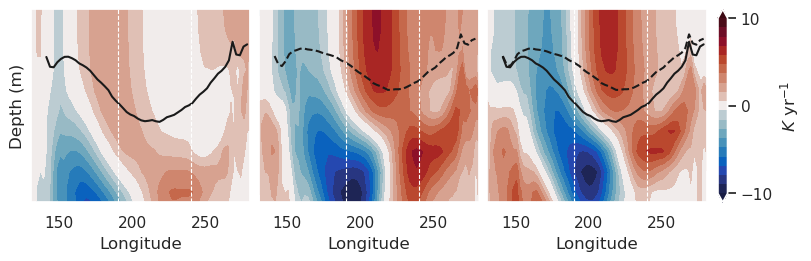

In [20]:
## specify which period/month to plot
# sel = lambda x: x.mean("month")
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), layout="constrained")

for ax, m in zip(axs[:2], [m_early, m_late]):

    ## temperature
    cp = ax.contourf(
        m.lon,
        m.z_t,
        sel(m),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(10, 1),
        extend="both",
    )

## difference
axs[2].contourf(
    m.lon,
    m.z_t,
    sel(m_late - m_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(10, 1),
    extend="both",
)
## plot MLD
plot_mlds(axs=axs, sel=sel)

## label
cb = fig.colorbar(cp, ax=axs[2], ticks=[-10, 0, 10], label=r"$K~\text{yr}^{-1}$")
format_subsurf_axs(axs)
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()

### SST-$\tau_x$

In [98]:
## shared args
kwargs = dict(x_vars=["nino34"], y_var="taux")

## compute coefs
m_early = src.utils.multi_regress_bymonth(anom_early, **kwargs).to_dataarray().squeeze()
m_late = src.utils.multi_regress_bymonth(anom_late, **kwargs).to_dataarray().squeeze()

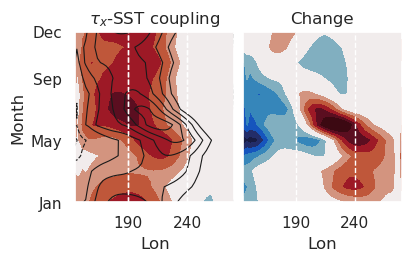

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), layout="constrained")

## plot data
cp0 = plot_cycle_hov(axs[0], data=m_early, amp=0.015)
plot_cycle_hov(axs[0], data=m_late, amp=0.015, is_filled=False)

## plot difference
cp2 = plot_cycle_hov(axs[1], data=m_late - m_early, amp=0.0075)

## make it look nicer
axs[1].set_yticks([])
axs[0].set_yticks([1, 5, 9, 12], labels=["Jan", "May", "Sep", "Dec"])
axs[0].set_ylabel("Month")
axs[0].set_title(r"$\tau_x$-SST coupling")
axs[1].set_title("Change")

# for ax in axs:
#     ax.set_xlim([150,280])

plt.show()

### $\tau_x-T_{sub}$

In [115]:
## specify T variable
T_var = "nino34"

kwargs = dict(x_vars=[T_var, "h_w_hat"], y_var="T")
# kwargs = dict(x_vars=["nino34"],  y_var="T")

m_early = src.utils.multi_regress_bymonth(anom_sub_early, **kwargs)[T_var]
m_late = src.utils.multi_regress_bymonth(anom_sub_late, **kwargs)[T_var]

In [116]:
## specify max depth for entrainment zone (relative to base of ML)
ez_depth = 20

## get vertical grad
dT_early = -get_dT_sub(Tsub=m_early, mld=mld_early, delta=ez_depth)
dT_late = -get_dT_sub(Tsub=m_late, mld=mld_late, delta=ez_depth)

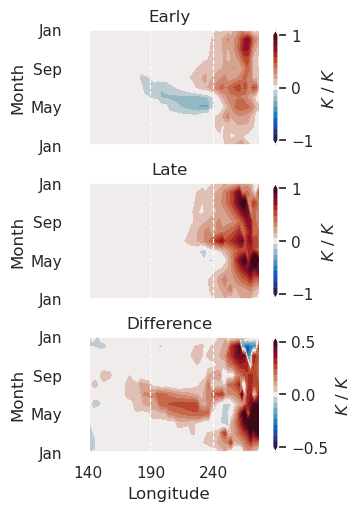

In [117]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(1e0, 1e-1), extend="both"
)
cb_kwargs = dict(ticks=[-1, 0, 1], label=r"$K~/~K$")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], dT_early, **kwargs)
cb0 = fig.colorbar(cp0, ax=axs[0], **cb_kwargs)

# ## plot late
cp1 = src.utils.plot_cycle_hov(axs[1], dT_late, **kwargs)
cb1 = fig.colorbar(cp1, ax=axs[1], **cb_kwargs)

## plot difference
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    dT_late - dT_early,
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(0.5e0, 0.5e-1),
    extend="both",
)

cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[-0.5, 0, 0.5], label=r"$K~/~K$")

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

plt.show()

In [118]:
## shared kwargs
kwargs = dict(x_var="taux", y_var="T")

## function to get slope
get_slope = lambda x, fn_x: x.groupby("time.month").map(
    src.utils.regress_proj, fn_x=fn_x, **kwargs
)

## then, reconstruct regression coefficient
m_early = get_slope(anom_sub_early, fn_x=src.utils.get_nino34)
m_late = get_slope(anom_sub_late, fn_x=src.utils.get_nino34)
# m_early = get_slope(anom_sub_early, fn_x=src.utils.get_nino4)
# m_late = get_slope(anom_sub_early, fn_x=src.utils.get_nino34)

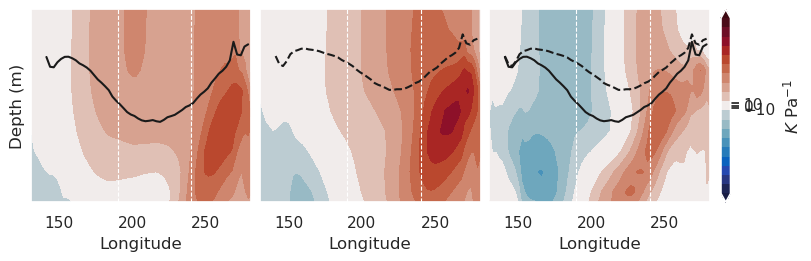

In [119]:
## specify which period/month to plot
# sel = lambda x: x.mean("month")
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), layout="constrained")

for ax, m in zip(axs[:2], [m_early, m_late]):

    ## temperature
    cp = ax.contourf(
        m.lon,
        m.z_t,
        sel(m),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(200, 20),
        extend="both",
    )

## difference
axs[2].contourf(
    m.lon,
    m.z_t,
    sel(m_late - m_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(100, 10),
    extend="both",
)
## plot MLD
plot_mlds(axs=axs, sel=sel)

## label
cb = fig.colorbar(cp, ax=axs[2], ticks=[-10, 0, 10], label=r"$K~\text{Pa}^{-1}$")
format_subsurf_axs(axs)
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()

In [120]:
## specify max depth for entrainment zone (relative to base of ML)
ez_depth = 20

## get vertical grad
dT_early = -get_dT_sub(Tsub=m_early, mld=mld_early, delta=ez_depth)
dT_late = -get_dT_sub(Tsub=m_late, mld=mld_late, delta=ez_depth)

# dT_early = -get_dT_sub(Tsub=m_early, mld=mld_early, delta=ez_depth)
# dT_late = -get_dT_sub(Tsub=m_late, mld=mld_early, delta=ez_depth)

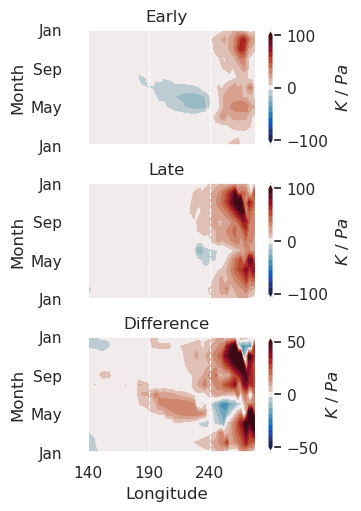

In [121]:
## make hövmöllers
fig, axs = plt.subplots(3, 1, figsize=(3.5, 5), layout="constrained")

## kwargs
kwargs = dict(
    cmap="cmo.balance", levels=src.utils.make_cb_range(1e2, 1e1), extend="both"
)
cb_kwargs = dict(ticks=[-100, 0, 100], label=r"$K~/~Pa$")

## plot early
cp0 = src.utils.plot_cycle_hov(axs[0], dT_early, **kwargs)
cb0 = fig.colorbar(cp0, ax=axs[0], **cb_kwargs)

# ## plot late
cp1 = src.utils.plot_cycle_hov(axs[1], dT_late, **kwargs)
cb1 = fig.colorbar(cp1, ax=axs[1], **cb_kwargs)

## plot difference
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    dT_late - dT_early,
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(5e1, 5e0),
    extend="both",
)

cb2 = fig.colorbar(cp2, ax=axs[2], ticks=[-50, 0, 50], label=r"$K~/~Pa$")

## label
axs[0].set_title("Early")
axs[1].set_title("Late")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

plt.show()

## ENSO composites

In [9]:
def get_composite(idx, data, peak_month, time_idx, q=0.95, is_warm=True):
    """
    Get hovmoller composite based on specified:
    - data: used to compute index/make composite
    - peak_month: month to center composite on
    - q: quantile threshold for composite
    """

    ## get data subset
    data_ = data.sel(time_idx)
    idx_ = idx.sel(time_idx)

    ## handle warm/cold case
    if is_warm:
        kwargs = dict(q=q, check_cutoff=lambda x, cut: x > cut)
    else:
        kwargs = dict(q=1 - q, check_cutoff=lambda x, cut: x < cut)

    ## kwargs for composite
    kwargs = dict(kwargs, peak_month=peak_month, idx=idx_, data=data_)

    ## composite of projected data
    comp_proj = src.utils.make_composite(**kwargs)

    return comp_proj


def get_spatial_composite(components, **composite_kwargs):
    """
    Get spatial composite
    """

    ## get projected composite
    comp_proj = get_composite(**composite_kwargs)

    ## reconstruct spatial fields
    comp = reconstruct_helper(comp_proj, components, func=lambda x: x).drop_vars("mode")

    ## reconstruct relative SST
    comp["sst_rel"] = comp["sst_total"] - comp["trop_sst_05"]

    return comp


def reconstruct_helper(composite, components, func):
    """reconstruction helper function for composite"""

    ## copy to hold reconstructed results
    composite_recon = copy.deepcopy(composite)

    ## reconstruct anomalies
    for c in list(components):
        composite_recon[c] = src.utils.reconstruct_fn(
            components=components[c],
            scores=composite[c],
            fn=func,
        )

    ## check for "total" fields
    for c in list(composite):
        if "_total" in c:
            n = c[:-6]
            composite_recon[c] = src.utils.reconstruct_fn(
                components=components[n],
                scores=composite[c],
                fn=func,
            )

    return composite_recon


def get_spatial_clim(forced, time_idx, lags, peak_month, components):
    """get climatologies of spatial variables"""

    ## reconstruct monthly climatology for period
    clim = src.utils.reconstruct_fn(
        scores=forced.sel(time_idx).groupby("time.month").mean(),
        components=components,
        fn=lambda x: x,
    )

    ## convert to lag coordinates
    months = 1 + np.mod(lags + peak_month - 1, 12)
    clim_comp = xr.concat(
        [clim.sel(month=m).drop_vars("month") for m in months],
        dim=lags,
    )

    return clim_comp


def add_advection_terms(comp, comp_clim, delta=5, H0=None):
    """add advection terms to composite"""

    ## copy composite
    comp_ = copy.deepcopy(comp)

    ## zonal velocity
    comp_["adv_uprime_Tbar"] = -get_udTdx(u=comp["u"], T=comp_clim["T"])
    comp_["adv_ubar_Tprime"] = -get_udTdx(T=comp["T"], u=comp_clim["u"])

    ## vertical velocity
    comp_["adv_wprime_Tbar"] = get_wdTdz(w=comp["w"], T=comp_clim["T"])
    comp_["adv_wbar_Tprime"] = get_wdTdz(T=comp["T"], w=comp_clim["w"])

    ## integrate over mixed layer
    for v in list(comp_):
        if "adv" in v:
            comp_[f"{v}_ml"] = get_ml_avg(
                comp_[v],
                Hm=comp_clim["mld"],
                delta=delta,
                H0=H0,
            )

    ## add together zonal adv and thermocline feedbacks
    comp_["Th_zaf_ml"] = comp_["adv_wbar_Tprime_ml"] + comp_["adv_uprime_Tbar_ml"]

    return comp_


def get_T_ml_tendency(T, mld, delta=5, H0=None):
    """compute mixed-layer temperature tendency"""

    ## integrate over mixed layer
    T_ml = get_ml_avg(T, Hm=mld, delta=delta, H0=H0)

    ## compute tendency
    return T_ml.differentiate("lag")


def get_spatial_composite_wrapper(
    forced_scores,
    components,
    peak_month,
    time_idx,
    delta=5,
    H0=None,
    **composite_kwargs,
):
    """
    Get spatial composite
    """

    ## shared args
    shared_args = dict(
        time_idx=time_idx,
        peak_month=peak_month,
    )

    ## get spatial composite of anomalies
    composite = get_spatial_composite(
        components=components,
        **shared_args,
        **composite_kwargs,
    )

    ## get background state
    comp_clim = get_spatial_clim(
        forced=forced_scores,
        lags=composite.lag,
        components=components[["u", "w", "T", "mld"]],
        **shared_args,
    )

    ## add advection terms
    composite = add_advection_terms(
        comp=composite, comp_clim=comp_clim, delta=delta, H0=H0
    )

    ## add mixed-layer temperature tendency
    composite["ddt_T"] = get_T_ml_tendency(
        composite["T"],
        mld=comp_clim["mld"],
        delta=delta,
        H0=H0,
    )

    ## add SST tendency
    ddt_sst = composite["sst"].differentiate("lag").rename({"longitude": "lon"})
    composite["ddt_sst"] = ddt_sst.interp({"lon": composite.lon.values})

    ## get NHF in units of K/mo
    sec_per_mo = 8.64e4 * 30
    rho = 1.02e3
    Cp = 4.2e3
    H = comp_clim["mld"]
    # H = 50
    Q = composite["nhf"] * sec_per_mo / (rho * Cp * H)
    Q = Q.rename({"longitude": "lon"})
    composite["Q"] = Q.interp({"lon": composite.lon.values})

    return composite

### Compute

Subset of data for making composite

In [10]:
## create data array for computing composite
comp_data = xr.merge(
    [
        anom[["sst", "pr", "ssh", "mld", "nhf"]],  # anomalies
        scores[["sst", "pr"]].rename({"sst": "sst_total", "pr": "pr_total"}),
        eli["eli_05"],
        trop_sst["trop_sst_05"],
        anom_sub[["T", "u", "w"]],
    ]
)

## get components
comp_components = xr.merge(
    [components[["sst", "ssh", "pr", "mld", "nhf"]], components_sub[["T", "u", "w"]]]
)

Compute

In [11]:
## specify shared args
kwargs = dict(
    peak_month=12,
    q=0.95,
    idx=Th["T_34"],
    is_warm=True,
    data=comp_data,
    components=comp_components,
    delta=10,
    H0=None,
)

## specify early/late times
t_idx_early = dict(time=slice("1851", "1880"))
t_idx_late = dict(time=slice("2071", "2100"))

comp_early = get_spatial_composite_wrapper(
    forced_scores=xr.merge([forced_sub, forced["mld"]]),
    time_idx=t_idx_early,
    **kwargs,
)
comp_late = get_spatial_composite_wrapper(
    forced_scores=xr.merge([forced_sub, forced["mld"]]),
    time_idx=t_idx_late,
    **kwargs,
)

## hovmoller version
merimean = lambda x: x.sel(latitude=slice(-5, 5)).mean("latitude")
hov_comp_early = merimean(comp_early).transpose("lag", ...)
hov_comp_late = merimean(comp_late).transpose("lag", ...)

/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/glade/u/home/kcarr/RO-change-over-time/envs/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


### Plot

#### SST hovmoller

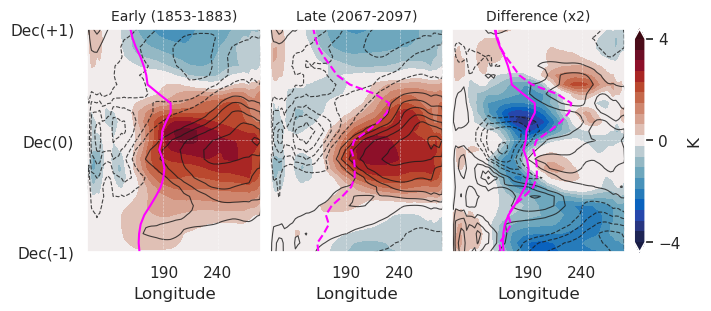

In [12]:
## specify amplitudes for plots
scales = np.array([4 / 3, 4 / 3, 4 / 3])

## set up plot
fig, axs = plt.subplots(1, 3, figsize=(7, 3), layout="constrained")

for ax, merimean, scale in zip(
    axs, [hov_comp_early, hov_comp_late, 2 * (hov_comp_late - hov_comp_early)], scales
):
    cf, _ = src.utils.plot_hov(ax=ax, x=merimean, beta=scale)
    ax.set_xticks([])
    ax.set_yticks([])

    ## label x axis
    ax.set_xlabel("Longitude")
    ax.set_xticks([190, 240])
    ax.set_yticks([])

## label
font_kwargs = dict(size=10)
axs[0].set_title("Early (1853-1883)", **font_kwargs)
axs[1].set_title("Late (2067-2097)", **font_kwargs)
axs[2].set_title("Difference (x2)", **font_kwargs)
cb = fig.colorbar(cf, ax=axs[2], ticks=[-4, 0, 4], label="K")
src.utils.label_hov_yaxis(axs[0], peak_mon=kwargs["peak_month"])

## plot ELI
axs[0].plot(
    comp_early["eli_05"],
    comp_early.lag,
    c="magenta",
)
axs[1].plot(comp_late["eli_05"], comp_late.lag, c="magenta", ls="--")
axs[2].plot(comp_early["eli_05"], comp_early.lag, c="magenta", ls="-")
axs[2].plot(comp_late["eli_05"], comp_late.lag, c="magenta", ls="--")

plt.show()

#### Relative SST and precip

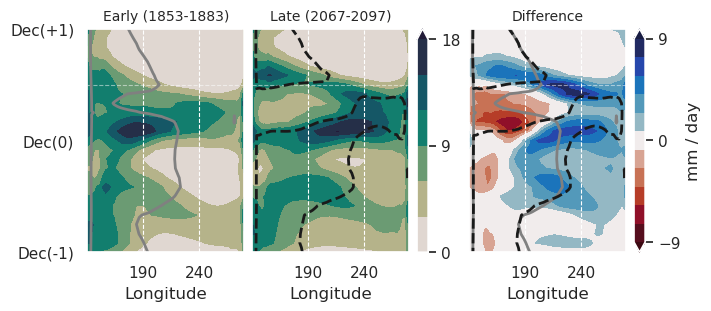

In [13]:
## set up plot
fig, axs = plt.subplots(1, 3, figsize=(7, 3), layout="constrained")

## plot  composite for each period
for ax, merimean in zip(axs[:2], [hov_comp_early, hov_comp_late]):

    cf = ax.contourf(
        merimean.longitude,
        merimean.lag,
        8.6e4 * merimean["pr_total"],
        cmap="cmo.rain",
        levels=np.arange(0, 21, 3),
        extend="max",
    )


## plot difference
cf_diff = axs[2].contourf(
    merimean.longitude,
    merimean.lag,
    8.6e4 * (hov_comp_late - hov_comp_early)["pr_total"],
    cmap="cmo.balance_r",
    levels=src.utils.make_cb_range(9, 1.5),
    extend="both",
)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

    ## label x axis
    ax.set_xlabel("Longitude")
    ax.set_xticks([190, 240])
    ax.set_yticks([])
    ax.set_xlim([140, 280])
    ax.axvline(190, c="w", ls="--", lw=0.8)
    ax.axvline(240, c="w", ls="--", lw=0.8)
    ax.axhline(6, c="w", ls="--", lw=0.8, alpha=0.5)

## label
font_kwargs = dict(size=10)
axs[0].set_title("Early (1853-1883)", **font_kwargs)
axs[1].set_title("Late (2067-2097)", **font_kwargs)
axs[2].set_title("Difference", **font_kwargs)
cb = fig.colorbar(cf, ax=axs[1], ticks=[0, 9, 18])
cb_diff = fig.colorbar(cf_diff, ax=axs[2], ticks=[-9, 0, 9], label="mm / day")
src.utils.label_hov_yaxis(axs[0], peak_mon=kwargs["peak_month"])

## plot ELI

## plot zero line
for ax, hov, ls, c in zip(
    axs[:2], [hov_comp_early, hov_comp_late], ["-", "--"], ["gray", "k"]
):
    ax.contour(
        hov.longitude,
        hov.lag,
        hov["sst_rel"],
        levels=[0],
        colors=c,
        linestyles=ls,
        linewidths=2,
    )

for hov, ls, c in zip([hov_comp_early, hov_comp_late], ["-", "--"], ["gray", "k"]):
    axs[2].contour(
        hov.longitude,
        hov.lag,
        hov["sst_rel"],
        levels=[0],
        colors=c,
        linestyles=ls,
        linewidths=2,
    )

plt.show()

#### Advection terms

In [14]:
def format_hov_ax(ax):
    """format hovmoller ax"""

    ax.set_xticks([])
    ax.set_yticks([])

    ## label x axis
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([140, 280])
    ax.axvline(190, c="w", ls="--", lw=0.8)
    ax.axvline(240, c="w", ls="--", lw=0.8)
    for t, c in zip([-6, 0, 6], ["w", "k", "w"]):
        ax.axhline(t, c=c, ls="--", lw=0.8, alpha=0.5)
    # ax.axhline(-4, c="w", ls="--", lw=0.8, alpha=0.5)

    return

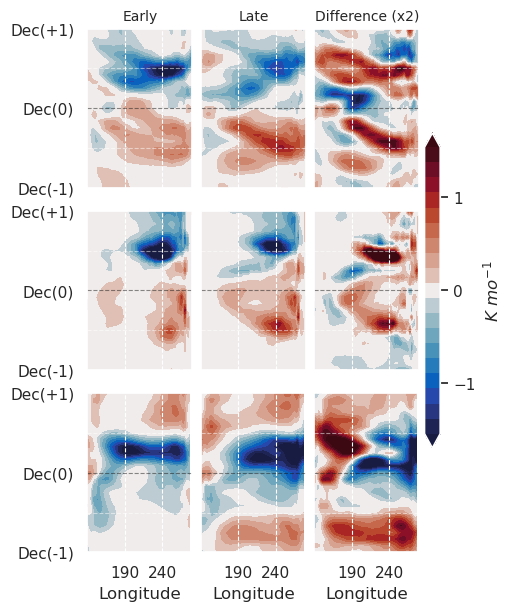

In [15]:
#### specify which terms to plot

## tendency and zonal advective
# plot_vars = ["adv_uprime_Tbar_ml", "ddt_T"]
# plot_vars = ["ddt_T", "adv_wbar_Tprime_ml", "Th_zaf_ml"]
# plot_vars = ["ddt_sst", "adv_wbar_Tprime_ml", "Th_zaf_ml"]
plot_vars = ["ddt_T", "Th_zaf_ml", "Q"]

## thermocline and zonal feedbacks
# plot_vars = ["adv_wbar_Tprime_ml", "adv_uprime_Tbar_ml"]

## thermocline and ekman
# plot_vars = ["adv_wbar_Tprime_ml", "adv_wprime_Tbar_ml"]

#### set up plot
fig, axs = plt.subplots(3, 3, figsize=(5, 6), layout="constrained")

## specify plotting specs
plot_kwargs = dict(
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(1.5, 0.15),
    extend="both",
)

for row_i, plot_var in enumerate(plot_vars):

    ## plot  composite for each period
    for col_i, merimean in enumerate([hov_comp_early, hov_comp_late]):

        ## plot absolute
        cf = axs[row_i, col_i].contourf(
            merimean.lon,
            merimean.lag,
            merimean[plot_var],
            **plot_kwargs,
        )

    ## plot difference
    cf_diff = axs[row_i, 2].contourf(
        merimean.lon,
        merimean.lag,
        2 * (hov_comp_late - hov_comp_early)[plot_var],
        **plot_kwargs,
    )

for ax in axs.flatten():

    format_hov_ax(ax)

## label
font_kwargs = dict(size=10)
axs[0, 0].set_title("Early", **font_kwargs)
axs[0, 1].set_title("Late", **font_kwargs)
axs[0, 2].set_title("Difference (x2)", **font_kwargs)

cb = fig.colorbar(cf, ax=axs[:, 2], ticks=[-1, 0, 1], label=r"$K~mo^{-1}$")

for ax in axs[:, 0]:
    src.utils.label_hov_yaxis(ax, peak_mon=kwargs["peak_month"])

for ax in axs[-1, :]:
    ax.set_xlabel("Longitude")
    ax.set_xticks([190, 240])


plt.show()

#### Spatial patterns

Relative SST and precip

In [16]:
def plot_sst_rel(ax, data):
    """plot relative sst on ax object"""

    cp = ax.contourf(
        data.longitude,
        data.latitude,
        data["sst_rel"],
        cmap="cmo.balance",
        transform=ccrs.PlateCarree(),
        levels=src.utils.make_cb_range(10, 1),
        extend="both",
    )

    return cp


def plot_contour(ax, data, lev, lw, c="k"):
    """plot relative sst on ax object"""

    cp = ax.contour(
        data.longitude,
        data.latitude,
        data["sst_rel"],
        transform=ccrs.PlateCarree(),
        levels=[lev],
        linewidths=lw,
        colors=c,
    )

    return cp


def plot_pr(ax, data):
    """plot precip on ax object"""

    ## convert from kg / m / s to mm/day
    ## 1e-3 (m3 / kg) * 1e3 (mm / m) * 8.6e4 (s / day)
    factor = 8.6e4

    cp = ax.contourf(
        data.longitude,
        data.latitude,
        factor * data["pr_total"],
        cmap="cmo.rain",
        transform=ccrs.PlateCarree(),
        levels=np.arange(0, 28, 4),
        extend="max",
    )

    return cp

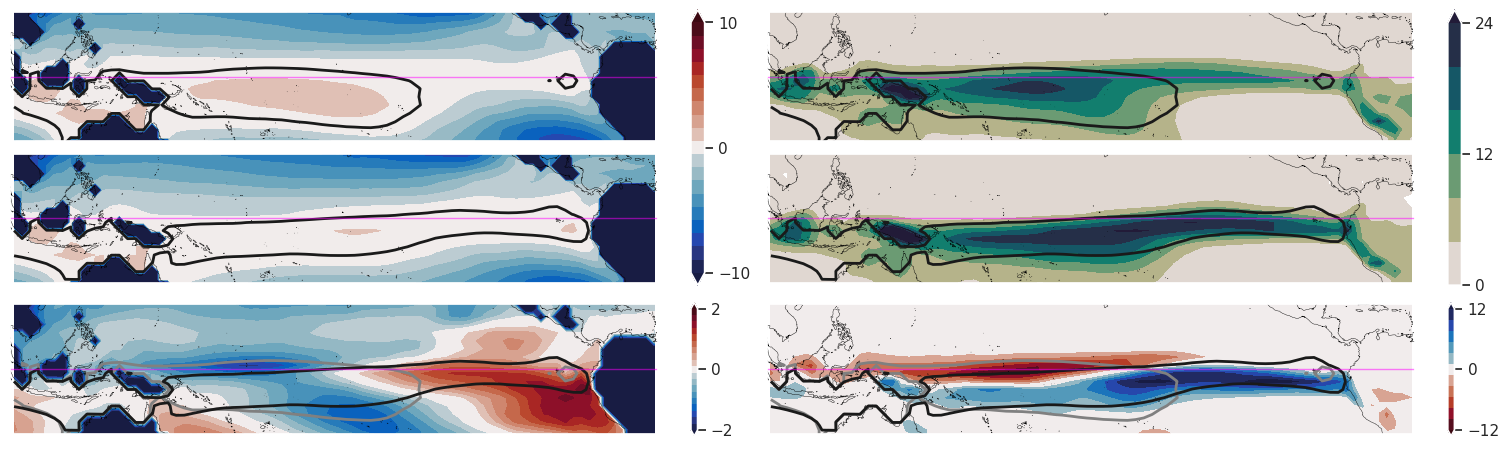

In [17]:
## specify which month to look at
sel = lambda x: x.sel(lag=2)

fig = plt.figure(figsize=(15, 4.375), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=2, format_func=format_func)

## plot early
cp0 = plot_sst_rel(axs[0, 0], sel(comp_early))
cp1 = plot_pr(axs[0, 1], sel(comp_early))

## plot late
plot_sst_rel(axs[1, 0], sel(comp_late))
plot_pr(axs[1, 1], sel(comp_late))

## plot diff
cp0_ = axs[2, 0].contourf(
    comp_early.longitude,
    comp_early.latitude,
    sel((comp_late - comp_early)["sst_rel"]),
    cmap="cmo.balance",
    transform=ccrs.PlateCarree(),
    levels=src.utils.make_cb_range(2, 0.2),
    extend="both",
)

cp1_ = axs[2, 1].contourf(
    comp_early.longitude,
    comp_early.latitude,
    8.6e4 * sel((comp_late - comp_early)["pr_total"]),
    cmap="cmo.balance_r",
    transform=ccrs.PlateCarree(),
    levels=src.utils.make_cb_range(12, 2),
    extend="both",
)

## plot convective bounds
for ax in axs[0, :]:
    plot_contour(ax, sel(comp_early), lev=0, lw=2)
    # plot_contour(ax, sel(comp_early), lev=-1, lw=1)

for ax in axs[1, :]:
    plot_contour(ax, sel(comp_late), lev=0, lw=2)
    # plot_contour(ax, sel(comp_late), lev=-1, lw=1)

for ax in axs[2]:
    plot_contour(ax, sel(comp_early), lev=0, lw=2, c="gray")
    plot_contour(ax, sel(comp_late), lev=0, lw=2)

for ax in axs.flatten():
    ax.axhline(0, c="magenta", lw=1, alpha=0.5)

## colorbars
fig.colorbar(cp0, ax=axs[:2, 0], ticks=[-10, 0, 10])
fig.colorbar(cp1, ax=axs[:2, 1], ticks=[0, 12, 24])
fig.colorbar(cp0_, ax=axs[2, 0], ticks=[-2, 0, 2])
fig.colorbar(cp1_, ax=axs[2, 1], ticks=[-12, 0, 12])

plt.show()

SST and precip anom

In [18]:
def plot_sst_anom(ax, data, amp=2):
    """plot relative sst on ax object"""

    cp = ax.contourf(
        data.longitude,
        data.latitude,
        data["sst"],
        cmap="cmo.balance",
        transform=ccrs.PlateCarree(),
        levels=src.utils.make_cb_range(amp, amp / 10),
        extend="both",
    )

    return cp


def plot_pr_anom(ax, data, amp=20):
    """plot precip on ax object"""

    ## convert from kg / m / s to mm/day
    ## 1e-3 (m3 / kg) * 1e3 (mm / m) * 8.6e4 (s / day)
    factor = 8.6e4

    cp = ax.contourf(
        data.longitude,
        data.latitude,
        factor * data["pr"],
        cmap="cmo.balance_r",
        transform=ccrs.PlateCarree(),
        levels=src.utils.make_cb_range(amp, amp / 10),
        extend="both",
    )

    return cp

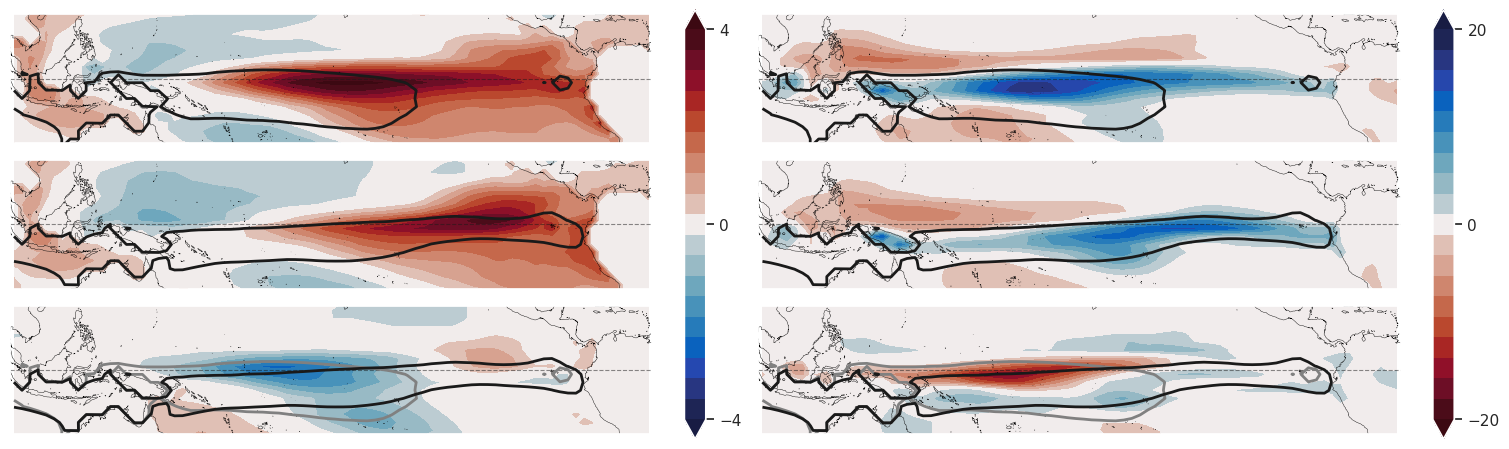

In [19]:
## specify amplitudes for each plot
sst_amp = 3.5
pr_amp = 20

## specify which month to look at
sel = lambda x: x.sel(lag=2)

fig = plt.figure(figsize=(15, 4.375), layout="constrained")
format_func = lambda ax,: src.utils.plot_setup_pac(ax, max_lat=20)
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=2, format_func=format_func)

## plot early
cp0 = plot_sst_anom(axs[0, 0], sel(comp_early), amp=sst_amp)
cp1 = plot_pr_anom(axs[0, 1], sel(comp_early))

## plot late
plot_sst_anom(axs[1, 0], sel(comp_late), amp=sst_amp)
plot_pr_anom(axs[1, 1], sel(comp_late), amp=pr_amp)

## plot diff
cp0_diff = plot_sst_anom(
    axs[2, 0],
    sel(comp_late - comp_early),
    amp=sst_amp,
)

cp1_diff = plot_pr_anom(
    axs[2, 1],
    sel(comp_late - comp_early),
    amp=pr_amp,
)


for ax in axs.flatten():
    ax.axhline(0, c="k", lw=0.8, alpha=0.5, ls="--")

## plot convective bounds
for ax in axs[0, :]:
    plot_contour(ax, sel(comp_early), lev=0, lw=2)
    # plot_contour(ax, sel(comp_early), lev=-1, lw=1)

for ax in axs[1, :]:
    plot_contour(ax, sel(comp_late), lev=0, lw=2)
    # plot_contour(ax, sel(comp_late), lev=-1, lw=1)

for ax in axs[2]:
    plot_contour(ax, sel(comp_early), lev=0, lw=2, c="gray")
    plot_contour(ax, sel(comp_late), lev=0, lw=2)

## colorbars
fig.colorbar(cp0, ax=axs[:, 0], ticks=[-4, 0, 4])
fig.colorbar(cp1, ax=axs[:, 1], ticks=[-20, 0, 20])

plt.show()

## Budget

### Load heat budget data

In [4]:
## path to cesm data
CESM_FP = DATA_FP / "cesm"


def load_var(varname):
    """load variable from prepped folder"""

    data = xr.open_mfdataset(
        sorted(list(pathlib.Path(CESM_FP, f"{varname}_temp").glob("*.nc"))),
        concat_dim="member",
        combine="nested",
    )

    return data.assign_coords({"member": np.arange(100)})


## load data
data = xr.merge([load_var(v) for v in ["uet", "vnt", "wtt"]])

## update z-coord in WTT
data["WTT"] = (
    data["WTT"].rename({"z_w_top": "z_t"}).assign_coords({"z_t": data.z_t.values})
)
data = data.drop_vars("z_w_top")

## get total advection tendency
data["ADV"] = data["UET"] + data["VNT"] + data["WTT"]

### Merge and get forced component

In [5]:
## merge
data = xr.merge([data, Th])

## get early/late
data_early = data.sel(time=slice("1850", "1879")).compute()
data_late = data.sel(time=slice("2071", "2100")).compute()

## get forced component
forced_early, anom_early = src.utils.separate_forced(data_early)
forced_late, anom_late = src.utils.separate_forced(data_late)

### regression

In [8]:
def regress(data, y_var, x_vars):
    """multiple linear regression"""

    ## Get covariates and targets
    X = data[x_vars].to_dataarray(dim="i")
    Y = data[y_var]

    ## compute covariance matrices
    YXt = xr.cov(Y, X, dim=["member", "time"])
    XXt = xr.cov(X, X.rename({"i": "j"}), dim=["member", "time"])

    ## invert XX^T
    XXt_inv = xr.zeros_like(XXt)
    XXt_inv.values = np.linalg.inv(XXt.values)

    ## get least-squares fit, YX^T @ (XX^T)^{-1}
    m = (YXt * XXt_inv).sum("i")

    return m.to_dataset(dim="j")


def regress_bymonth(data, y_var, x_vars):
    """do multiple linear regression for each month separately"""
    return data.groupby("time.month").map(regress, y_var=y_var, x_vars=x_vars)

In [11]:
kwargs = dict(x_vars=["T_34"], y_var="ADV")

m_early = regress_bymonth(anom_early, **kwargs)["T_34"]
m_late = regress_bymonth(anom_late, **kwargs)["T_34"]

Note: this is flux, not divergence...

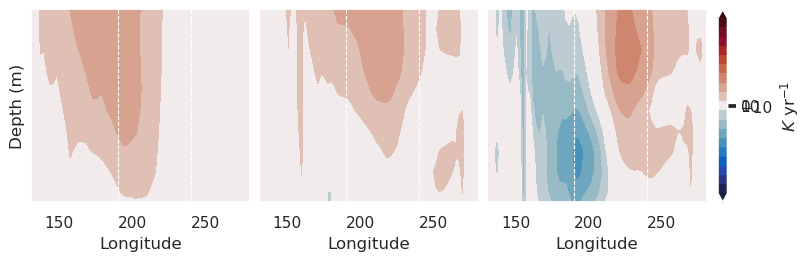

In [21]:
SEC_PER_MO = 8.64e4 * 30

## specify which period/month to plot
# sel = lambda x: x.mean("month")
sel = lambda x: x.sel(month=7)

fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), layout="constrained")

for ax, m in zip(axs[:2], [m_early, m_late]):

    ## temperature
    cp = ax.contourf(
        m.lon,
        m.z_t / 100,
        SEC_PER_MO * sel(m),
        cmap="cmo.balance",
        levels=src.utils.make_cb_range(500, 50),
        extend="both",
    )

## difference
axs[2].contourf(
    m.lon,
    m.z_t / 100,
    SEC_PER_MO * sel(m_late - m_early),
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(250, 25),
    extend="both",
)
## plot MLD
# plot_mlds(axs=axs, sel=sel)

## label
cb = fig.colorbar(cp, ax=axs[2], ticks=[-10, 0, 10], label=r"$K~\text{yr}^{-1}$")
format_subsurf_axs(axs)
for ax in axs:
    ax.set_ylim([100, 5])
    ax.axvline(190, ls="--", c="w", lw=0.8)
    ax.axvline(240, ls="--", c="w", lw=0.8)

plt.show()